In [5]:
import matplotlib.pyplot as plt
import pde
import numpy as np
import torch
import pandas as pd
from torch.nn import functional as F


from numpy import pi
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

#plt.rcParams['figure.figsize'] = [10, 10]

In [6]:
def solveEquationPYPDE(variable, eq, ic="cos(pi*x)", xrange=None, yrange=None, points=500, trange=1):
    #initialize xrange
    if xrange is None:
        xrange = [-1, 1]
    
    #eq is passed in as a string with x as the dependent variable
    eq = pde.PDE({variable: eq})
    
    if yrange is not None:
        grid = pde.grids.CartesianGrid([xrange, yrange], [points], periodic=[True, True])
    else:
        grid = pde.grids.CartesianGrid([xrange], [points],  periodic=True)
    
    field = pde.ScalarField.from_expression(grid, ic)

    storage = pde.MemoryStorage()
    trackers = ['progress', storage.tracker(interval=0.001)]
    #bc = ["periodic", {'derivative': 'periodic'}]
    #field /= np.sqrt(field.to_scalar('norm_squared').integral.real)

    solver = pde.ExplicitSolver(eq, backend='numba' ,scheme='runge-kutta', adaptive=True, tolerance=1e-9)
    controller = pde.Controller(solver, t_range=trange, tracker=trackers)
    solution = controller.run(field, dt=1e-6)
    
    return field, storage

In [7]:
s1, st1 = solveEquationPYPDE('phi', f"- phi * d_dx(phi) - 0.0025 * laplace(d_dx(phi))")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.0/1.0 [00:12<00:00, 12.50s/it]


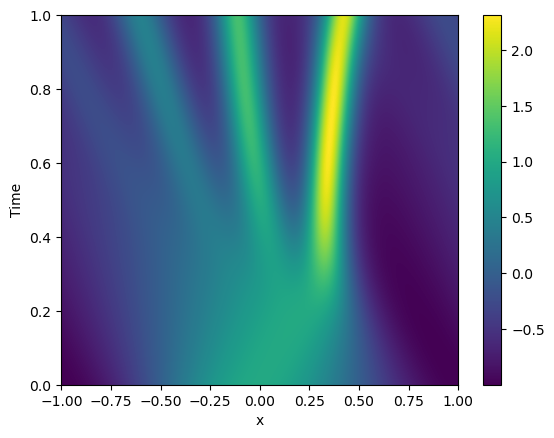

In [8]:
pde.plot_kymograph(st1)

In [5]:
x = s1.get_line_data()['data_x'].reshape(-1,1) # X x 1
t = np.array(st1.times).reshape(-1,1) # T x 1
x_grid, t_grid = np.meshgrid(x, t)


phi = np.array(st1.data)
#u = np.real(phi) #.flatten().reshape(-1,1)[::10].reshape(79,30)   #.flatten()[:,None]
#v = np.imag(phi) #.flatten().reshape(-1,1)[::10].reshape(79,30)  #.flatten()[:,None]

#plt.pcolormesh(x_grid, t_grid, np.sqrt(u**2 + v**2))

##Generate the two indices
idx1 = np.random.choice(x_grid.shape[0], 105, replace=False)
idx1 = np.sort(idx1)
idx2 = np.random.choice(x_grid.shape[1], 100, replace=False)
idx2 = np.sort(idx2)

def gen_train(grid):
    grid_new = grid[idx1]
    grid_new = grid_new[:,idx2]
    return grid_new
    
x_train, t_train, phi_train = gen_train(x_grid), gen_train(t_grid), gen_train(phi)

## attempt to plot
##plt.pcolormesh(x_train, t_train, phi_train)

In [6]:
## reshape to feed into model
x_train = x_train.flatten()[:,None]
t_train = t_train.flatten()[:,None]

phi_train = phi_train.flatten()[:,None]
print(x_train.shape, t_train.shape, phi_train.shape)

(10500, 1) (10500, 1) (10500, 1)


In [10]:
## boilerplate stuff for GPU...
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

## create gridmesh for plotting
x_axis = torch.linspace(-1, 1, 100)
t_axis = torch.linspace(0, 1, 100)

x_grid, t_grid = torch.meshgrid(x_axis, t_axis, indexing='xy')
xt_pairs = torch.stack((x_grid, t_grid), dim=2)
xt_pairs = xt_pairs.reshape(xt_pairs.shape[0] * xt_pairs.shape[1],2).to(device)

TRAIN_STEPS = 150000

class PINN():
    def __init__(self, x, t, phi):
        self.x = torch.tensor(x, dtype=torch.float32, requires_grad=True, device=device)
        self.t = torch.tensor(t, dtype=torch.float32, requires_grad=True, device=device)
        
        self.phi = torch.tensor(phi, dtype=torch.float32, device=device)
        
        self.null = torch.zeros((self.x.shape[0],1), device=device)

        self.net_init()

        ## for learning the parameters?
        self.lam_1 = torch.nn.Parameter(torch.tensor(0., requires_grad=True, device=device))
        self.lam_2 = torch.nn.Parameter(torch.tensor(0., requires_grad=True, device=device))
        
        self.optim = torch.optim.Adam(list(self.net.parameters())+[self.lam_1, self.lam_2], lr=3e-4)
        #self.optim = torch.optim.LBFGS(list(self.net.parameters())+[self.lam_1, self.lam_2],
        #                               lr=1,
        #                               max_iter=50000,
        #                               max_eval=50000,
        #                               history_size=50,
        #                               tolerance_grad=1e-8,
        #                               tolerance_change=0.5 * np.finfo(float).eps,
        #                               line_search_fn='strong_wolfe'
        #                              )

        self.lams_1 =  []
        self.lams_2 =  []
        
        self.mse = torch.nn.MSELoss()
        self.ls = 0
        self.step = 0
        print(self.x.shape, self.t.shape, self.phi.shape)
    
    def net_init(self, dDim=64, act=torch.nn.Tanh):
        self.net = torch.nn.Sequential(
            torch.nn.Linear(2, dDim),act(),
            torch.nn.Linear(dDim, dDim),act(),
            torch.nn.Linear(dDim, dDim),act(),
            torch.nn.Linear(dDim, dDim),act(),
            torch.nn.Linear(dDim, dDim),act(),
            torch.nn.Linear(dDim, 1)
        )
        self.net.to(device)
    
    def func(self, x, t):
        phi = self.net(torch.hstack((x, t)))

        phi_t = torch.autograd.grad(phi, t, torch.ones_like(phi), create_graph=True)[0]
        phi_x = torch.autograd.grad(phi, x, torch.ones_like(phi), create_graph=True)[0]
        phi_xx = torch.autograd.grad(phi_x, x, torch.ones_like(phi_x), create_graph=True)[0]
        phi_xxx = torch.autograd.grad(phi_xx, x, torch.ones_like(phi_xx), create_graph=True)[0]

        f_phi = phi_t + self.lam_1 * phi * phi_x + self.lam_2 * phi_xxx

        return phi, f_phi
        
    def closure(self):
        self.optim.zero_grad(set_to_none=True)

        phi_pred, f_phi_pred = self.func(self.x, self.t)
        
        phi_loss = self.mse(phi_pred, self.phi)
        f_phi_loss = self.mse(f_phi_pred, self.null)
        self.ls = phi_loss + f_phi_loss
        self.ls.backward()

        self.lams_1.append(self.lam_1.item())
        self.lams_2.append(self.lam_2.item())

        if not self.step % 1000:
            print(f"Data loss: {phi_loss.item()}, Function loss: {f_phi_loss.item()}")
            print(f"Step: {self.step}, Loss: {self.ls}")

        
        ## plot the solution and learned parameter values
        if not self.step % 5000:
            pred = self.net(xt_pairs).reshape((100,100)).detach().cpu()
            plt.pcolormesh(x_grid, t_grid, pred)
            plt.show()
            
            plt.hlines(1, 0, len(self.lams_1), label='lam_1 true', color='tab:grey')
            plt.ylim(0,1.01)
            plt.plot(self.lams_1, label='lam_1 preds', color='tab:green')
            plt.legend()
            plt.show()
            
            plt.hlines(0.0025, 0, len(self.lams_2), label='lam_2 true', color='tab:grey')
            plt.ylim(0,0.0026)
            plt.plot(self.lams_2, label='lam_2 preds', color='tab:green')
            plt.legend()
            plt.show()
            
        self.step += 1
        return self.ls

    def train(self):
        self.net.train()
        for i in range(TRAIN_STEPS):
            self.optim.step(self.closure)

In [11]:
kdv_inverse = PINN(x_train, t_train, phi_train)

torch.Size([10500, 1]) torch.Size([10500, 1]) torch.Size([10500, 1])


Data loss: 0.5437700152397156, Function loss: 0.00012477322889026254
Step: 0, Loss: 0.5438947677612305


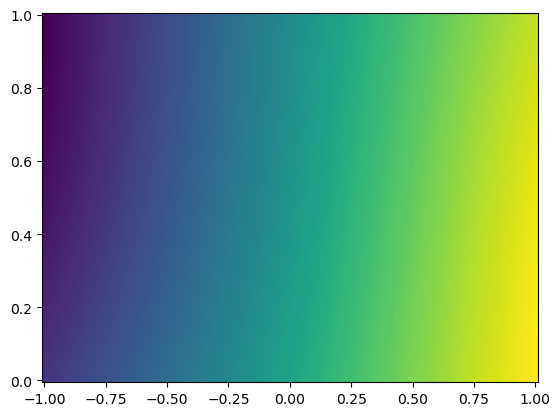

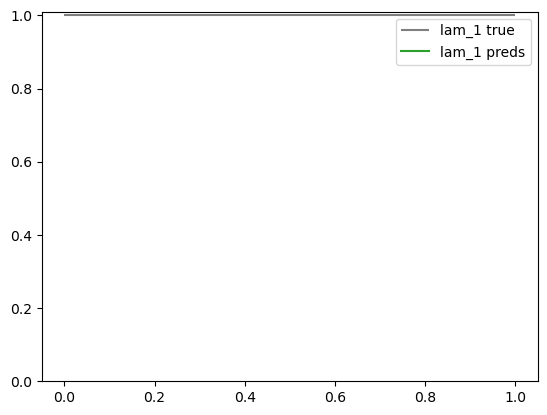

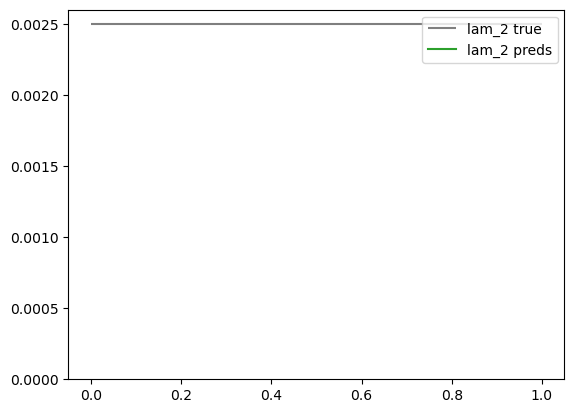

/usr/lib/python3.11/site-packages/torch/autograd/__init__.py:266: UserWarning: grad and param do not obey the gradient layout contract. This is not an error, but may impair performance.
grad.sizes() = [10500, 1], strides() = [1, 0]
param.sizes() = [10500, 1], strides() = [1, 0] (Triggered internally at /build/python-pytorch/src/pytorch-cuda/torch/csrc/autograd/functions/accumulate_grad.h:219.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Data loss: 0.2881050109863281, Function loss: 0.0006580135086551309
Step: 1000, Loss: 0.28876301646232605
Data loss: 0.2877686023712158, Function loss: 0.00027440188569016755
Step: 2000, Loss: 0.28804299235343933
Data loss: 0.28761667013168335, Function loss: 0.0001576053909957409
Step: 3000, Loss: 0.2877742648124695
Data loss: 0.28749531507492065, Function loss: 0.00010413466225145385
Step: 4000, Loss: 0.28759944438934326
Data loss: 0.29294997453689575, Function loss: 0.0003007144550792873
Step: 5000, Loss: 0.2932506799697876


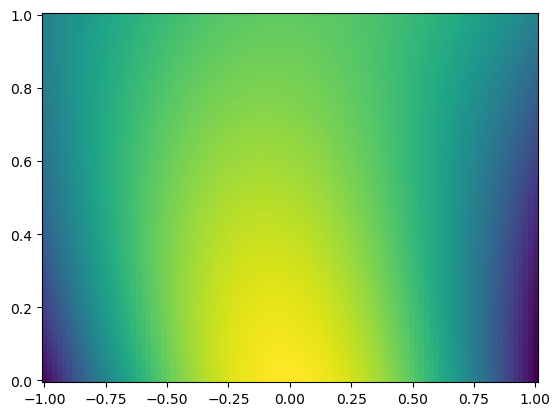

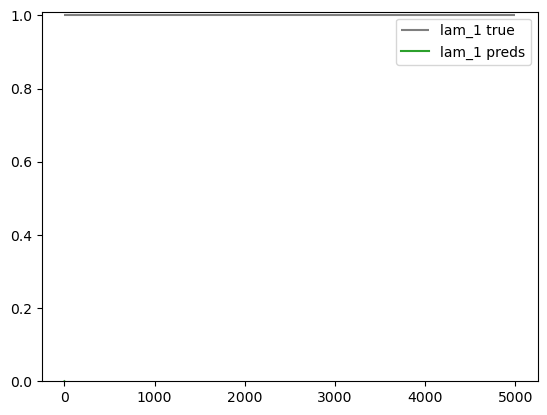

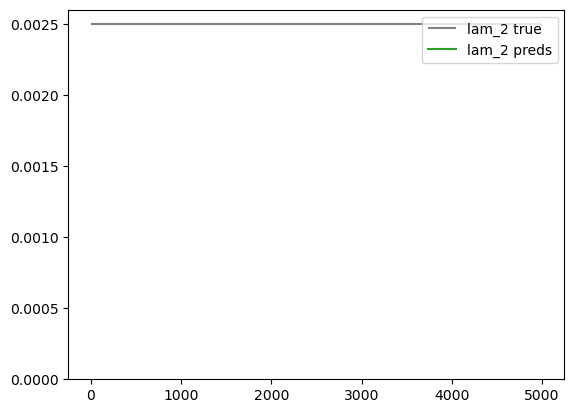

Data loss: 0.28727200627326965, Function loss: 6.142674101283774e-05
Step: 6000, Loss: 0.2873334288597107
Data loss: 0.2874165177345276, Function loss: 0.0001885719393612817
Step: 7000, Loss: 0.28760507702827454
Data loss: 0.28708603978157043, Function loss: 5.199839506531134e-05
Step: 8000, Loss: 0.28713804483413696
Data loss: 0.2878272235393524, Function loss: 0.00011485432332847267
Step: 9000, Loss: 0.2879420816898346
Data loss: 0.2870025038719177, Function loss: 6.995525473030284e-05
Step: 10000, Loss: 0.28707244992256165


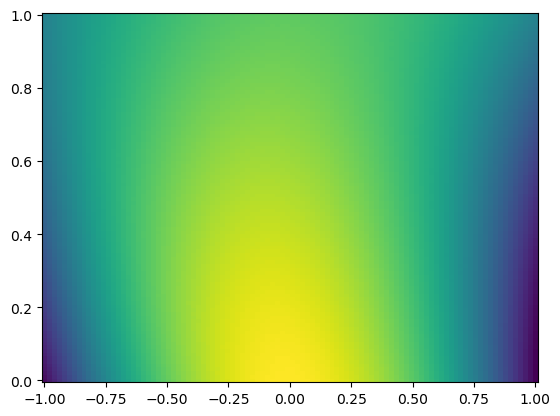

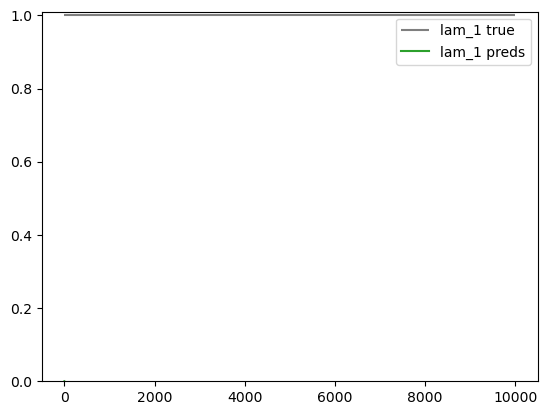

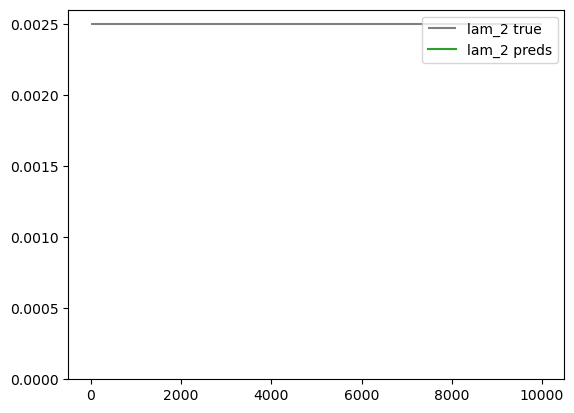

KeyboardInterrupt: 

In [12]:
kdv_inverse.train()

In [ ]:
## figure out plots for rectangular regions!!
x_axis = torch.linspace(-1, 1, 1001)
t_axis = torch.linspace(0, 1, 500)
x_grid, t_grid = torch.meshgrid(x_axis, t_axis, indexing='xy')
xt_pairs = torch.stack((x_grid, t_grid), dim=2)
xt_pairs = xt_pairs.reshape(x_grid.shape[0] * t_grid.shape[1],2).to(device)

pred = kdv_inverse.net(xt_pairs).reshape((1001,500)).detach().cpu()
plt.pcolormesh(x_grid.T, t_grid.T, pred)
plt.show()

In [ ]:
torch.mean(torch.tensor(st1.data)-pred)

In [ ]:
kdv_inverse.lam_1, kdv_inverse.lam_2

In [ ]:
torch.exp(torch.tensor(0.0))

In [ ]:
x_grid.shape

In [13]:
kdv_inverse.lams_2

[1.0,
 0.9997000694274902,
 0.9994328022003174,
 0.9991637468338013,
 0.9988832473754883,
 0.9986026883125305,
 0.998322606086731,
 0.9980403184890747,
 0.9977543950080872,
 0.9974640607833862,
 0.9971696138381958,
 0.9968711137771606,
 0.9965689778327942,
 0.996263325214386,
 0.9959540963172913,
 0.9956409931182861,
 0.9953235983848572,
 0.9950013160705566,
 0.9946740865707397,
 0.9943417310714722,
 0.9940044283866882,
 0.9936620593070984,
 0.9933149218559265,
 0.9929627776145935,
 0.9926056861877441,
 0.9922434687614441,
 0.991876482963562,
 0.9915049076080322,
 0.9911292195320129,
 0.9907501935958862,
 0.9903683662414551,
 0.9899843335151672,
 0.9895983934402466,
 0.9892107844352722,
 0.9888218641281128,
 0.9884318113327026,
 0.988040566444397,
 0.9876485466957092,
 0.9872555136680603,
 0.9868617057800293,
 0.9864670634269714,
 0.9860714077949524,
 0.9856744408607483,
 0.9852759838104248,
 0.9848757386207581,
 0.9844734072685242,
 0.984068751335144,
 0.9836612939834595,
 0.983250975

In [14]:
xt_pairs.shape

torch.Size([10000, 2])

In [ ]:
st1.